In [1]:
stock_symbol = 'BTC-USD'  # Beispiel: PLTR, kann angepasst werden
#import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt

# Dow Theorie: Trendanalyse
def dow_theory(data):
    # Identifikation von Aufwärtstrends und Abwärtstrends (basiert auf Schlusskursen)
    data['Trend'] = np.where(data['close'] > data['close'].shift(1), '1', '0')
    return data



# Elliott Wellen Theorie: Eine einfache Methode zur Identifikation von Wellen
def elliott_wave(data):
    # Berechnung der Rückgänge und Anstiege (ein rudimentäres Beispiel)
    data['Wave_Up'] = np.where(data['close'] > data['close'].shift(1), 1, 0)
    data['Wave_Down'] = np.where(data['close'] < data['close'].shift(1), 1, 0)
    
    # Identifikation von Wellen (dies ist ein vereinfachtes Beispiel)
    data['Wave_Count'] = data['Wave_Up'].cumsum() - data['Wave_Down'].cumsum()
    return data

# Daten laden
#df = yf.download('TSLA', start='2020-01-01')


folderPath_His = "/Users/Shared/ai_work/Trainingdata/ml_data/yh_his/D1/"


lastBars = 20
n_time_steps = 60 # Anzahl der Zeitstufen
n_pred_days3 = 60 # Anzahl der Vorhersagetage
n_tail= 200
df = pd.read_csv (folderPath_His + stock_symbol + ".csv")
print (df.head())
df_his = df.tail(lastBars+1)
df_his["date"] = pd.to_datetime(df["date"])
#dt.strftime('%Y-%m-%d')


#df["date"] = df["date"].apply(lambda x: pd.to_datetime(x, format='%Y-%m-%d'))
df["date"] = pd.to_datetime(df["date"], format='%Y-%m-%d')

df = df.set_index('date')
df = dow_theory(df)

df = elliott_wave(df)
df = df[:len(df) - lastBars]

print (df)
#df['AUDUSD_close'] = df['AUDUSD_close'].shift(1)
"""
df = df[['open', 'high', 'low', 'close','volume','AUDUSD_close','F_TNote_10Y_close','F_TNote_10Y_volume','cot_noncom_long','cot_com_short',
         'cot_noncom_short','cot_openinterest','F_TYield_13W_close','F_US_TBond_close','F_US_TBond_volume','F_VIX_close',
         'F_USDX_close','Trend','Wave_Down','Wave_Up','Wave_Count']]
"""
df1 = df[['open', 'high', 'low', 'close', 'volume']]
df['MA_14'] = df['close'].rolling(window=14).mean()
df['MA_50'] = df['close'].rolling(window=50).mean()
df['MA_200'] = df['close'].rolling(window=200).mean()
df['RSI_14'] = 100 - (100 / (1 + df['close'].pct_change().add(1).rolling(14).apply(lambda x: (x[x > 0].mean() / abs(x[x < 0].mean())) if abs(x[x < 0].mean()) > 0 else 0)))
df['Sentiment'] = np.random.uniform(-1, 1, size=len(df))  # Dummy

ema12 = df['close'].ewm(span=12, adjust=False).mean()
ema26 = df['close'].ewm(span=26, adjust=False).mean()
df['MACD'] = ema12 - ema26

df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()
df['Returns'] = round( df['close'].pct_change() , 5 )
df['MA200_diff'] = round( ((df['close'] - df['MA_200'])/df['close'] ), 5 )
df.dropna(inplace=True)
if n_tail > 0: df = df.tail(n_tail)
#'MA_14','MA_50', 'RSI_14'
features = [  'volume', 'open', 'high','low'
            ]
#features = ['open', 'high', 'low', 'volume', 'MA_14', 'RSI_14', 'F_TNote_10Y_close','F_TYield_13W_close','F_VIX_close','F_USDX_close']
target = 'close'


   Unnamed: 0   symbol        date        open        high         low  \
0           0  BTC-USD  2014-09-17  465.864014  468.174011  452.421997   
1           1  BTC-USD  2014-09-18  456.859985  456.859985  413.104004   
2           2  BTC-USD  2014-09-19  424.102997  427.834991  384.532013   
3           3  BTC-USD  2014-09-20  394.673004  423.295990  389.882996   
4           4  BTC-USD  2014-09-21  408.084991  412.425995  393.181000   

        close    volume    adjclose   ticker type  id  dividends  splits  
0  457.334015  21056800  457.334015  BTC-USD   D1   0        0.0     0.0  
1  424.440002  34483200  424.440002  BTC-USD   D1   1        0.0     0.0  
2  394.795990  37919700  394.795990  BTC-USD   D1   2        0.0     0.0  
3  408.903992  36863600  408.903992  BTC-USD   D1   3        0.0     0.0  
4  398.821014  26580100  398.821014  BTC-USD   D1   4        0.0     0.0  
            Unnamed: 0   symbol           open           high            low  \
date                     

/tmp/ipykernel_2313568/1625410347.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_his["date"] = pd.to_datetime(df["date"])


In [2]:
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_x.fit_transform(df[features])
y_scaled = scaler_y.fit_transform(df[[target]])

def create_sequences(X, y, time_steps=n_time_steps):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:i+time_steps].flatten())  # Flatten für sklearn
        ys.append(y[i+time_steps])
    return np.array(Xs), np.array(ys)

X_seq, y_seq = create_sequences(X_scaled, y_scaled)


In [3]:
model = MLPRegressor(hidden_layer_sizes=(128, 64), activation='relu', solver='adam', max_iter=500, random_state=42)
model.fit(X_seq, y_seq.ravel())


,loss,'squared_error'
,hidden_layer_sizes,"(128, ...)"
,activation,'relu'
,solver,'adam'
,alpha,0.0001
,batch_size,'auto'
,learning_rate,'constant'
,learning_rate_init,0.001
,power_t,0.5
,max_iter,500
,shuffle,True


In [4]:
last_input = X_scaled[-n_time_steps:]  # letzte 30 Tage
predictions = []

for _ in range(n_pred_days):
    X_input = last_input.flatten().reshape(1, -1)
    pred_scaled = model.predict(X_input)[0]
    predictions.append(pred_scaled)

    # Neues Feature-Sample simulieren
    new_row = last_input[-1].copy()
    new_row[-1] = pred_scaled  # close-Simulation als letztes Feature (Sentiment bleibt gleich hier)
    last_input = np.vstack((last_input[1:], new_row))

# Zurückskalieren
predicted_prices = scaler_y.inverse_transform(np.array(predictions).reshape(-1, 1))


NameError: name 'n_pred_days' is not defined

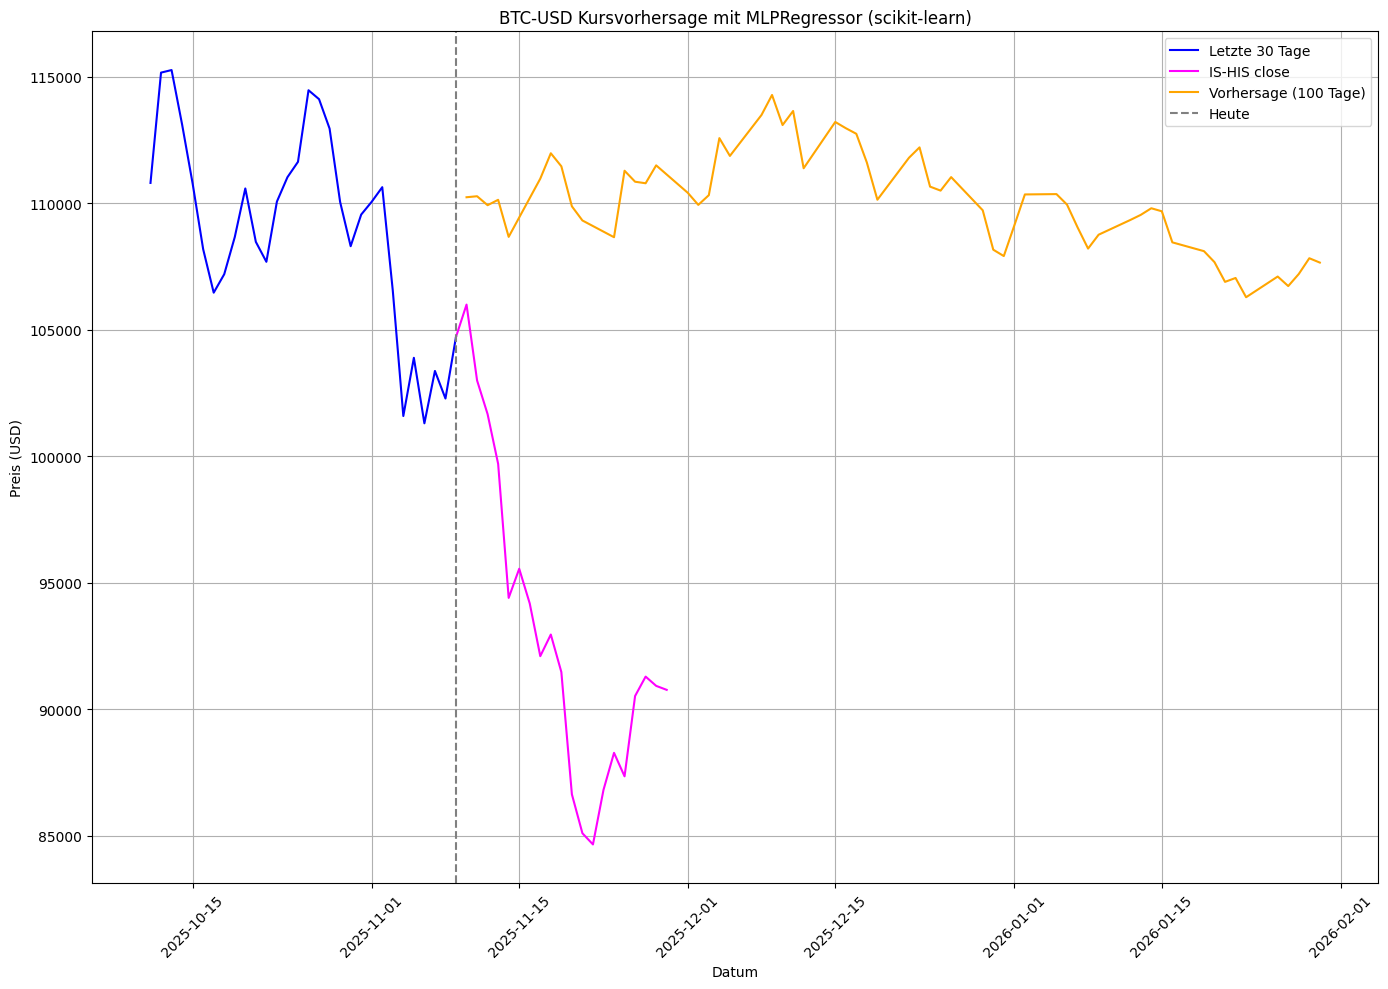

In [ ]:
import matplotlib.dates as mdates

df.index = pd.to_datetime(df.index)
last_date = df.index[-1]
future_dates = pd.date_range(last_date + pd.Timedelta(days=1), periods=n_pred_days, freq='B')
df_fc = ['date','fc']

#plt.figure(figsize=(40, 22))
plt.figure(figsize=(14, 10))
plt.plot(df.index[-30:], df['close'].iloc[-30:], label='Letzte 30 Tage', color='blue')
#plt.plot(df.index[-30:], df['trend'].iloc[-30:], label='Down Theory', color='blue')
plt.plot(df_his['date'], df_his['close'], label='IS-HIS close', color='magenta')
plt.plot(future_dates, predicted_prices, label='Vorhersage (100 Tage)', color='orange')
plt.axvline(x=last_date, color='gray', linestyle='--', label='Heute')
plt.title(stock_symbol + ' Kursvorhersage mit MLPRegressor (scikit-learn)')
plt.xlabel('Datum')
plt.ylabel('Preis (USD)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
print (predicted_prices)

[[110241.32995481]
 [110281.20804481]
 [109926.68224506]
 [110140.30021103]
 [108674.57190328]
 [110976.15376012]
 [111980.80869001]
 [111465.1958575 ]
 [109882.9652312 ]
 [109322.3957815 ]
 [108660.93245105]
 [111289.92346438]
 [110855.46220039]
 [110794.2624919 ]
 [111502.55334083]
 [110417.68935704]
 [109939.51731164]
 [110323.97551272]
 [112578.85061746]
 [111875.21160225]
 [113494.43160347]
 [114285.66391359]
 [113096.27651689]
 [113652.33845002]
 [111387.56833222]
 [113218.00475145]
 [112972.67872212]
 [112750.25426235]
 [111613.69733119]
 [110142.95259419]
 [111802.67035394]
 [112213.18550967]
 [110661.48647486]
 [110503.24962605]
 [111037.69329891]
 [109725.5854048 ]
 [108166.69656367]
 [107915.43684388]
 [109126.14380463]
 [110352.31962951]
 [110365.59503508]
 [109949.70015567]
 [109052.40285149]
 [108210.98113818]
 [108759.94063321]
 [109340.79522989]
 [109544.1093142 ]
 [109805.90821093]
 [109686.06808062]
 [108457.22973509]
 [108109.47307139]
 [107674.54712948]
 [106895.094

In [ ]:

#df1  = pd.DataFrame (future_dates)
df2  = pd.DataFrame (predicted_prices)

dates = future_dates
values = predicted_prices

df1 = pd.DataFrame({'date': future_dates})

print (df1)

df1['NN'] = predicted_prices

print (df1)

         date
0  2025-11-10
1  2025-11-11
2  2025-11-12
3  2025-11-13
4  2025-11-14
5  2025-11-17
6  2025-11-18
7  2025-11-19
8  2025-11-20
9  2025-11-21
10 2025-11-24
11 2025-11-25
12 2025-11-26
13 2025-11-27
14 2025-11-28
15 2025-12-01
16 2025-12-02
17 2025-12-03
18 2025-12-04
19 2025-12-05
20 2025-12-08
21 2025-12-09
22 2025-12-10
23 2025-12-11
24 2025-12-12
25 2025-12-15
26 2025-12-16
27 2025-12-17
28 2025-12-18
29 2025-12-19
30 2025-12-22
31 2025-12-23
32 2025-12-24
33 2025-12-25
34 2025-12-26
35 2025-12-29
36 2025-12-30
37 2025-12-31
38 2026-01-01
39 2026-01-02
40 2026-01-05
41 2026-01-06
42 2026-01-07
43 2026-01-08
44 2026-01-09
45 2026-01-12
46 2026-01-13
47 2026-01-14
48 2026-01-15
49 2026-01-16
50 2026-01-19
51 2026-01-20
52 2026-01-21
53 2026-01-22
54 2026-01-23
55 2026-01-26
56 2026-01-27
57 2026-01-28
58 2026-01-29
59 2026-01-30
         date             NN
0  2025-11-10  110241.329955
1  2025-11-11  110281.208045
2  2025-11-12  109926.682245
3  2025-11-13  110140.300211
4

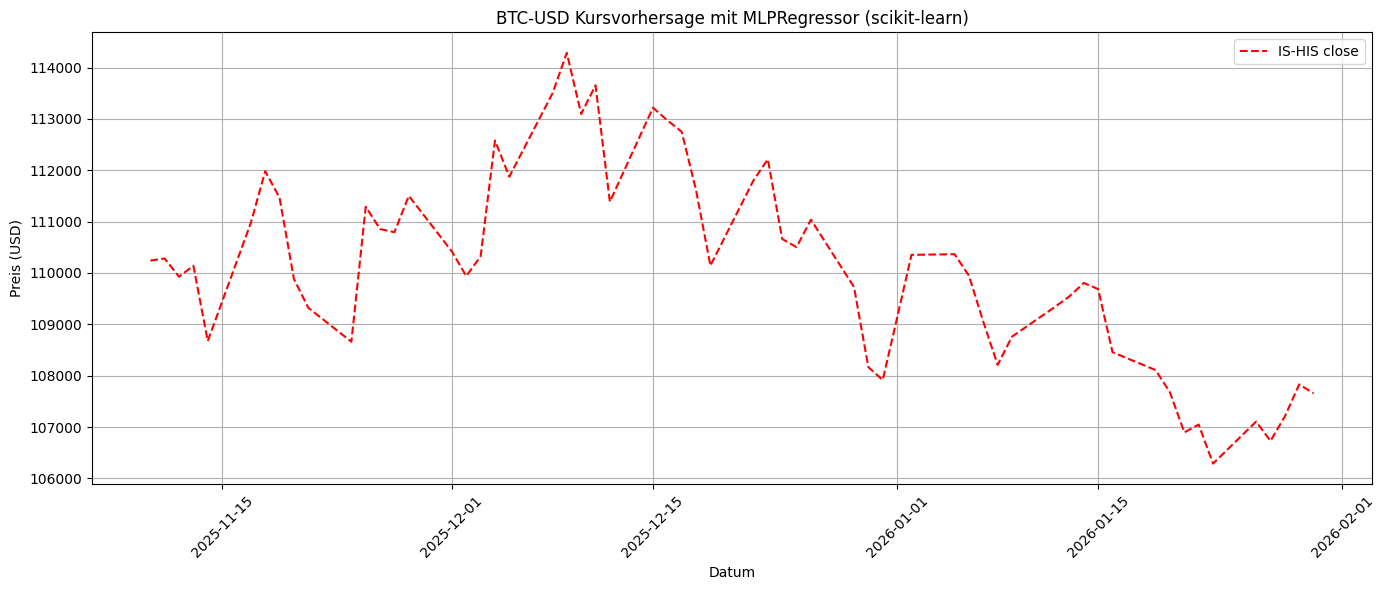

In [ ]:
df1["date"] = pd.to_datetime(df1["date"]) 
#df1 = df1.set_index('date')

plt.figure(figsize=(14, 6))
#plt.plot(df.index[-30:], df['close'].iloc[-30:], label='Letzte 30 Tage', color='blue')
plt.plot( df1['date'], df1['NN'], label='IS-HIS close', color='red',  linestyle='--' )

plt.title(stock_symbol + ' Kursvorhersage mit MLPRegressor (scikit-learn)')
plt.xlabel('Datum')
plt.ylabel('Preis (USD)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
#df1 = df1.set_index('date')
#df['NN'] = df1['NN'] 
print (df1)

         date             NN
0  2025-11-10  110241.329955
1  2025-11-11  110281.208045
2  2025-11-12  109926.682245
3  2025-11-13  110140.300211
4  2025-11-14  108674.571903
5  2025-11-17  110976.153760
6  2025-11-18  111980.808690
7  2025-11-19  111465.195858
8  2025-11-20  109882.965231
9  2025-11-21  109322.395781
10 2025-11-24  108660.932451
11 2025-11-25  111289.923464
12 2025-11-26  110855.462200
13 2025-11-27  110794.262492
14 2025-11-28  111502.553341
15 2025-12-01  110417.689357
16 2025-12-02  109939.517312
17 2025-12-03  110323.975513
18 2025-12-04  112578.850617
19 2025-12-05  111875.211602
20 2025-12-08  113494.431603
21 2025-12-09  114285.663914
22 2025-12-10  113096.276517
23 2025-12-11  113652.338450
24 2025-12-12  111387.568332
25 2025-12-15  113218.004751
26 2025-12-16  112972.678722
27 2025-12-17  112750.254262
28 2025-12-18  111613.697331
29 2025-12-19  110142.952594
30 2025-12-22  111802.670354
31 2025-12-23  112213.185510
32 2025-12-24  110661.486475
33 2025-12-25 

In [ ]:
#df_fc =  pd.DataFrame ( df[['open', 'high', 'close','NN']] )
#print (df_fc)

df_combined = pd.concat([df, df1], ignore_index=True)


In [ ]:
print (df_combined.tail(10) ) 

     Unnamed: 0 symbol  open  high  low  close  volume  adjclose ticker type  \
250         NaN    NaN   NaN   NaN  NaN    NaN     NaN       NaN    NaN  NaN   
251         NaN    NaN   NaN   NaN  NaN    NaN     NaN       NaN    NaN  NaN   
252         NaN    NaN   NaN   NaN  NaN    NaN     NaN       NaN    NaN  NaN   
253         NaN    NaN   NaN   NaN  NaN    NaN     NaN       NaN    NaN  NaN   
254         NaN    NaN   NaN   NaN  NaN    NaN     NaN       NaN    NaN  NaN   
255         NaN    NaN   NaN   NaN  NaN    NaN     NaN       NaN    NaN  NaN   
256         NaN    NaN   NaN   NaN  NaN    NaN     NaN       NaN    NaN  NaN   
257         NaN    NaN   NaN   NaN  NaN    NaN     NaN       NaN    NaN  NaN   
258         NaN    NaN   NaN   NaN  NaN    NaN     NaN       NaN    NaN  NaN   
259         NaN    NaN   NaN   NaN  NaN    NaN     NaN       NaN    NaN  NaN   

     ...  MA_50  MA_200  RSI_14 Sentiment  MACD  Signal_Line  Returns  \
250  ...    NaN     NaN     NaN       NaN   Na